In [870]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [871]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import waterfall_chart
from list_dict import rename_th_expend,region_list,region_dict,rename_country_dict
from format_func import format_th_arrival,format_th_expend,format_th_stay_expend,format_th_stay_expend_2020

## Reading data

In [872]:
# arrival number in thailand
th_arrival_2020 = pd.read_excel('data_source/2020_TH_no_of_arrival.xlsx',header=3)
th_arrival_2021 = pd.read_excel('data_source/2021_TH_no_of_arrival.xlsx',header=3)
th_arrival_2022 = pd.read_excel('data_source/2022_TH_no_of_arrival.xlsx',header=3)


# tourist expenditure thailand
th_expenditure_2018 = pd.read_excel('data_source/tourism_receipts_from_international_tourist_arrivals_by_expenditure_item_q_1_q_4_2018.xlsx'
,header=5,usecols='A:J')

th_expenditure_2019 = pd.read_excel('data_source/tourism_receipts_from_international_tourist_arrivals_by_expenditure_item_q_1_q_4_2019.xlsx'
,header=5,usecols='A:J')

# tourist expenditure v staying
th_stay_expend_2018 = pd.read_excel('data_source/tourism_receipts_from_international_tourist_arrivals_q_1_q_4_2018.xlsx'
,header=5,usecols='A:D,F')
th_stay_expend_2019 = pd.read_excel('data_source/tourism_receipts_from_international_tourist_arrivals_q_1_q_4_2019.xlsx'
,header=5,usecols='A:D,F')

th_stay_expend_2020 = pd.read_excel('data_source/tourist_expend_stay_2020.xlsx',header=3,usecols='B:D,N')

## Transforming

In [873]:
# format
th_arrival_2020 = format_th_arrival(th_arrival_2020)
th_arrival_2021 = format_th_arrival(th_arrival_2021)
th_arrival_2022 = format_th_arrival(th_arrival_2022)


th_expenditure_2018 = format_th_expend(th_expenditure_2018)
th_expenditure_2019 = format_th_expend(th_expenditure_2019)

th_stay_expend_2018 = format_th_stay_expend(th_stay_expend_2018)
th_stay_expend_2019 = format_th_stay_expend(th_stay_expend_2019)
th_stay_expend_2020 = format_th_stay_expend_2020(th_stay_expend_2020)

In [874]:
# get value vars
value_vars = th_expenditure_2018.columns.values.tolist()
value_vars.remove('Country')

# melt
# th_expenditure_2018_melt = pd.melt(th_expenditure_2018,id_vars='Country',value_vars=value_vars,var_name='Fields',value_name='2018')
# th_expenditure_2019_melt = pd.melt(th_expenditure_2019,id_vars='Country',value_vars=value_vars,var_name='Fields',value_name='2019')

# drop columns
th_arrival_2021.drop(columns=['2020P'],inplace=True)
th_arrival_2022.drop(columns=['2021P'],inplace=True)

In [875]:
# merge
th_arrival = pd.merge(th_arrival_2020,th_arrival_2021,how='inner',on='Nationality').merge(th_arrival_2022,how='inner',on='Nationality')
th_arrival = th_arrival[['Nationality', 2019,'2020P', '2021P', '2022P']]

th_arrival.rename(columns={2019:'2019','2020P':'2020','2021P':'2021','2022P':'2022'},inplace=True)

# th_expend = pd.merge(th_expenditure_2018_melt,th_expenditure_2019_melt,how='left',on=['Country','Fields'])
th_expend = pd.merge(th_expenditure_2018,th_expenditure_2019,how='left',on=['Country'])

# arrival per region
region_th_arrival = th_arrival.loc[th_arrival['Nationality'].isin(region_list)]

# expend per region
region_th_expend = th_expend.loc[th_expend['Country'].isin(region_list)]

# arrival per country
country_th_arrival = th_arrival.loc[~th_arrival['Nationality'].isin(region_list)]
country_th_expend = th_expend.loc[~th_expend['Country'].isin(region_list)]

# stay and spend per country
country_th_stay_spend_2018 = th_stay_expend_2018.loc[~th_stay_expend_2018['Country'].isin(region_list)]
country_th_stay_spend_2019 = th_stay_expend_2019.loc[~th_stay_expend_2018['Country'].isin(region_list)]

# stay and spend per region
region_th_stay_spend_2018 = th_stay_expend_2018.loc[th_stay_expend_2018['Country'].isin(region_list)]
region_th_stay_spend_2019 = th_stay_expend_2019.loc[th_stay_expend_2018['Country'].isin(region_list)]

In [876]:
# melt
region_th_arrival_melt = region_th_arrival.melt(id_vars='Nationality',value_vars=['2019','2020','2021','2022'],
                                                    value_name='num_arrival',var_name='year')

country_th_arrival_melt = country_th_arrival.melt(id_vars='Nationality',value_vars=['2019','2020','2021','2022'],
                                                    value_name='num_arrival',var_name='year')

In [877]:
# scale arrival from unit to million
region_th_arrival_melt['num_arrival'] = region_th_arrival_melt['num_arrival']/1000000
country_th_arrival_melt['num_arrival'] = country_th_arrival_melt['num_arrival']/1000000

#### Percent Change

In [878]:
country_th_arrival_melt.sort_values(by=['Nationality','year'],inplace=True)
region_th_arrival_melt.sort_values(by=['Nationality','year'],inplace=True)
country_th_arrival_melt['base_pct_change'] = country_th_arrival_melt.groupby('Nationality')['num_arrival'].pct_change()
##country_th_arrival_melt['base_pct_change'] = country_th_arrival_melt.groupby('Nationality')['num_arrival'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
region_th_arrival_melt['base_pct_change'] = region_th_arrival_melt.groupby('Nationality')['num_arrival'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
##country_th_arrival_melt['base_pct_change'] = (country_th_arrival_melt['num_arrival'] / country_th_arrival_melt.groupby('Nationality')['num_arrival'].shift(1) - 1) * 100


C:\Users\Karuntarat\AppData\Local\Temp\ipykernel_23192\3585374229.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  region_th_arrival_melt['base_pct_change'] = region_th_arrival_melt.groupby('Nationality')['num_arrival'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))


In [879]:
percent_change = country_th_arrival_melt.fillna(1).reset_index()
percent_change['base_pct_change'] = percent_change['base_pct_change'].apply(lambda x: x*100)
percent_change

,index,Nationality,year,num_arrival,base_pct_change
0,28,Argentina,2019,0.029498,100.000000
1,73,Argentina,2020,0.012457,-57.770018
2,118,Argentina,2021,0.000382,-96.933451
3,163,Argentina,2022,0.008206,2048.167539
4,37,Australia,2019,0.767162,100.000000
...,...,...,...,...,...
175,162,United Kingdom,2022,0.444432,1049.502108
176,8,Vietnam,2019,1.047663,100.000000
177,53,Vietnam,2020,0.132514,-87.351467
178,98,Vietnam,2021,0.001794,-98.646181


In [880]:
##Concatinate chinese expenditure

china_expend_18 = th_stay_expend_2018[th_stay_expend_2018['Country'] == 'China'].reset_index()
china_expend_18['year'] = 2018

china_expend_19 = th_stay_expend_2019[th_stay_expend_2019['Country'] == 'China'].reset_index()
china_expend_19['year'] = 2019

china_expend_20 = th_stay_expend_2020[th_stay_expend_2020['Nationality'] == 'China'].reset_index()
china_expend_20 = china_expend_20.pivot(index='Nationality', columns='Item', values='Values').reset_index()
china_expend_20['year'] = 2020
china_expend_20 = china_expend_20.rename(columns={'Nationality': 'Country', 'Number of Arrivals':'No. of Arrivals','Length of Stay':'Length of Stay (Days)','Per Capita Spending':'Spending per Capita (Baht/Day)','Tourism Receipts':'Total Spend (Mil. Baht)'})
china_expend_20 = china_expend_20.loc[:,['Country','No. of Arrivals','Length of Stay (Days)','Spending per Capita (Baht/Day)','Total Spend (Mil. Baht)','year']]

china_expend = china_expend_18.append(china_expend_19, ignore_index=False)
china_expend = pd.concat([china_expend_18, china_expend_19, china_expend_20])

C:\Users\Karuntarat\AppData\Local\Temp\ipykernel_23192\1623152451.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  china_expend = china_expend_18.append(china_expend_19, ignore_index=False)


## Arrival by Nationality

In [881]:
region_arrival = region_th_arrival_melt.groupby('Nationality')['num_arrival'].sum().sort_values()
df_region_arrival = pd.DataFrame({'Nationality': region_arrival.index, 'Total Arrivals': region_arrival.values})
df_region_arrival = df_region_arrival[df_region_arrival['Nationality'] != 'Asean']
df_region_arrival

,Nationality,Total Arrivals
0,Africa,0.292509
1,East Europe,1.030661
2,Middle East,1.281573
3,Oceania,1.410207
4,The Americas,2.603421
5,South Asia,3.914091
6,Europe,11.593394
8,East Asia,37.104347


## The Number of travellers visiting Thailand from 2019-2022

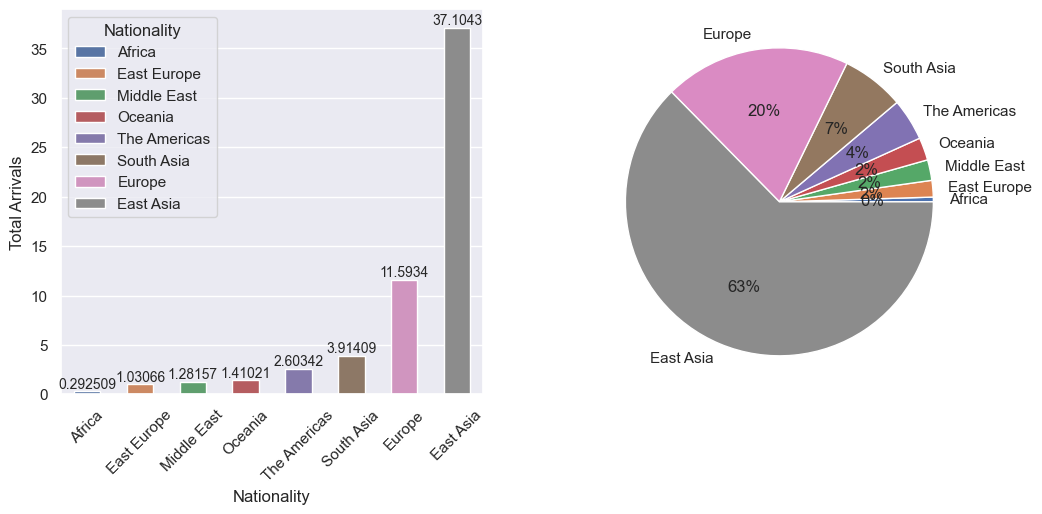

In [882]:
sns.set_style('darkgrid')

fig, (axes1,axes2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=df_region_arrival, x='Nationality', y='Total Arrivals', hue='Nationality', ax = axes1, width=0.5, dodge=False)
for p in axes1.containers:
    axes1.bar_label(p, label_type='edge', fontsize=10)
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=45)

axes2 = plt.pie(df_region_arrival['Total Arrivals'], labels=df_region_arrival['Nationality'], autopct='%.0f%%')


plt.show()

East Asia and Europe have the highest contribution amoung other regions. East asia and Europe have contributed for 63% and 20% respectively.

## East Asia

Considering the first contribution
* what nationality has entered Thailand the most from 2019-2022 (focus on the top three)
* How much money there countries in point 1 had spent in Thailand during the stay?
* See the relationship on how Covid had effected these people coming to Thailand?
* 


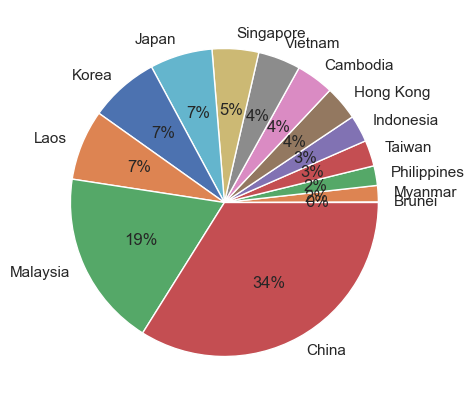

In [883]:
east_asian = percent_change[percent_change['Nationality'].isin(region_dict['East Asia'])]
east_asian = east_asian.groupby('Nationality')['num_arrival'].sum().sort_values().reset_index()
east_asian 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plt.pie(east_asian['num_arrival'], labels=east_asian['Nationality'], autopct='%.0f%%')


## China

### What was the change to the number of Chinese travellers since the pandamic? from 2019-2022


In [884]:
china_expend

,index,Country,No. of Arrivals,Length of Stay (Days),Spending per Capita (Baht/Day),Total Spend (Mil. Baht),year
0,11.0,China,10625167.0,7.76,6334.22,522264.78,2018
0,11.0,China,11138658.0,7.80,6118.41,531576.65,2019
0,NaN,China,1302137.0,9.86,5073.36,69719.61,2020


C:\Users\Karuntarat\AppData\Local\Temp\ipykernel_23192\577073104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china_expend['diff'].iloc[0] = china_expend['Total Spend (Mil. Baht)'].iloc[0]
c:\Users\Karuntarat\AppData\Local\Programs\Python\Python310\lib\site-packages\waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


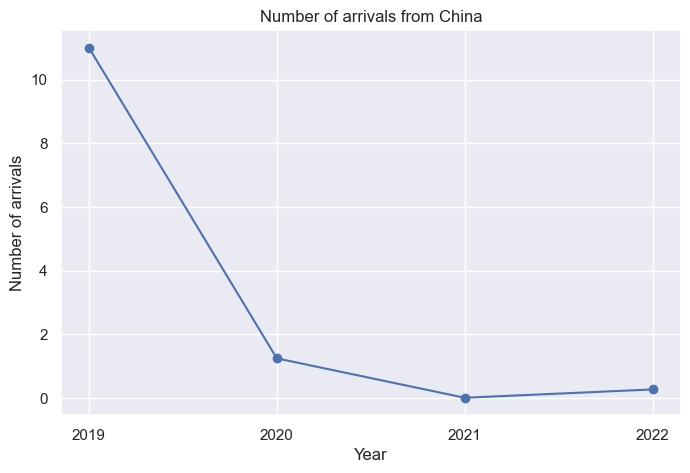

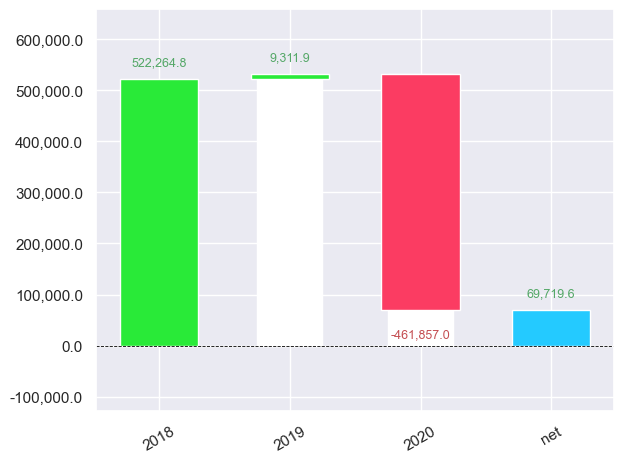

In [885]:
China_num = percent_change[percent_change['Nationality'] == 'China'].reset_index()

china_expend['diff'] = china_expend['Total Spend (Mil. Baht)'].diff()
china_expend['diff'].iloc[0] = china_expend['Total Spend (Mil. Baht)'].iloc[0]
china_expend['year'] = china_expend['year'].astype(str)

# Create the subplots
fig, (axes1) = plt.subplots(1, 1, figsize=(8, 5))

# First subplot: line plot of num_arrival over the years
axes1.plot(China_num['year'], China_num['num_arrival'], marker='o')
axes1.set_title('Number of arrivals from China')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of arrivals')

# Add annotations for base_pct_change values
for x, y in zip(China_num['year'], China_num['base_pct_change']):
    axes1.annotate(f'{round(y, 3)}', xy=(x, y), textcoords='data')


# Second subplot: waterfall chart
# Plot

waterfall_china = waterfall_chart.plot(china_expend['year'], china_expend['diff'])

##axes2.set_ylim(min(China_num_19_21['num_arrival']), max(China_num_19_21['num_arrival']))
plt.show()

# Malaysia

C:\Users\Karuntarat\AppData\Local\Temp\ipykernel_23192\1388303864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Malay_num_19_21['diff'] = Malay_num_19_21['num_arrival'].diff()
c:\Users\Karuntarat\AppData\Local\Programs\Python\Python310\lib\site-packages\waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


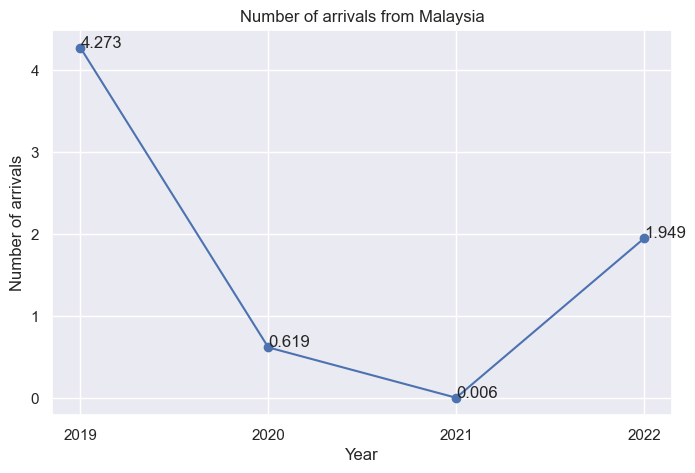

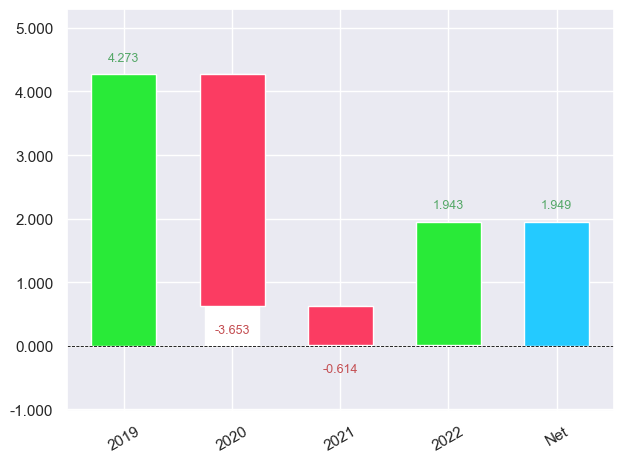

In [888]:
##import waterfall_chart

Malay_num = percent_change[percent_change['Nationality'] == 'Malaysia'].reset_index()
Malay_num_19_21 = Malay_num.iloc[0:4]
Malay_num_19_21['diff'] = Malay_num_19_21['num_arrival'].diff()
Malay_num_19_21.loc[0, 'diff'] = Malay_num_19_21['num_arrival'].iloc[0]
Malay_num_19_21


# Create the subplots
fig, axes1 = plt.subplots(1, 1, figsize=(8, 5))

# First subplot: line plot of num_arrival over the years
axes1.plot(Malay_num['year'], Malay_num['num_arrival'], marker='o')
axes1.set_title('Number of arrivals from Malaysia')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of arrivals')

# Add annotations for base_pct_change values
for x, y in zip(Malay_num['year'], Malay_num['num_arrival']):
    axes1.annotate(f'{round(y, 3)}', xy=(x, y), textcoords='data')


# Second subplot: waterfall chart
# Plot
##waterfall_chart.plot(Malay_num_19_21['year'],Malay_num_19_21['diff'],formatting="{:,.3f}")

waterfall_malay = waterfall_chart.plot(Malay_num_19_21['year'], Malay_num_19_21['diff'], formatting="{:,.3f}", 
                                  net_label="Net")

plt.show()


In [889]:
Malay_num_19_21

,level_0,index,Nationality,year,num_arrival,base_pct_change,diff
0,96,4,Malaysia,2019,4.272584,100.000000,4.272584
1,97,49,Malaysia,2020,0.619451,-85.501724,-3.653133
2,98,94,Malaysia,2021,0.005511,-99.110341,-0.613940
3,99,139,Malaysia,2022,1.948549,35257.448739,1.943038


### Discuss about income from Malaysian travellers

## Europe

Considering the first contribution
* what nationality has entered Thailand the most from 2019-2022 (focus on the top three)
* How much money there countries in point 1 had spent in Thailand during the stay?
* See the relationship on how Covid had effected these people coming to Thailand?
* 


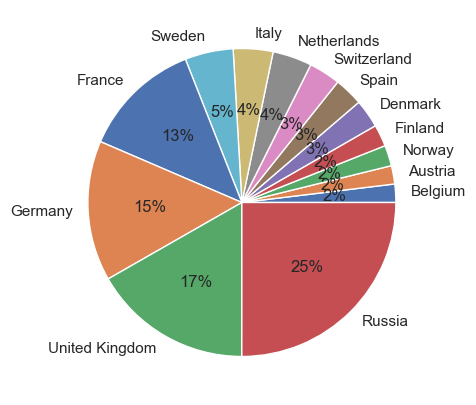

In [890]:
east_asian = percent_change[percent_change['Nationality'].isin(region_dict['Europe'])]
east_asian = east_asian.groupby('Nationality')['num_arrival'].sum().sort_values().reset_index()
east_asian 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plt.pie(east_asian['num_arrival'], labels=east_asian['Nationality'], autopct='%.0f%%')

## Russia

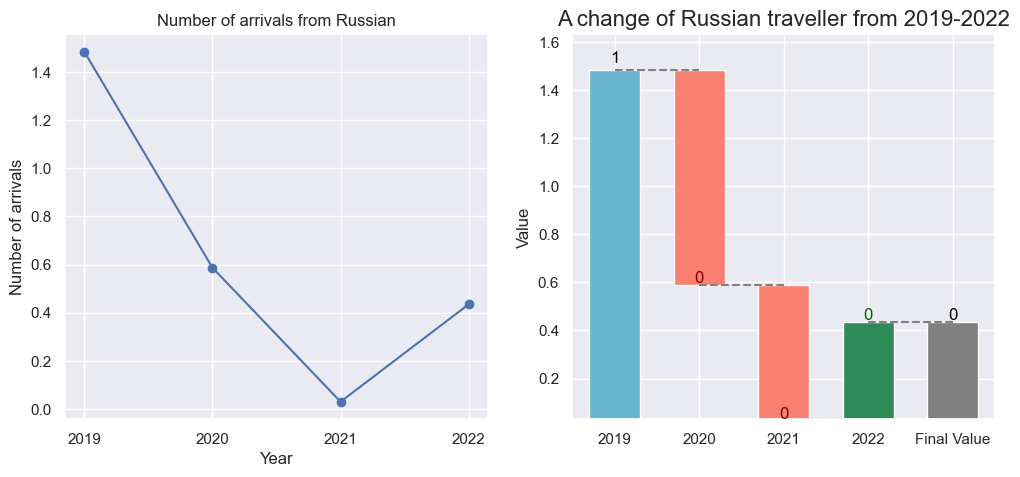

In [891]:
Russia = percent_change[percent_change['Nationality'] == 'Russia'].reset_index()
Russia_19_21 = Russia.iloc[0:4]

# Create the subplots
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: line plot of num_arrival over the years
axes1.plot(Russia['year'], Russia['num_arrival'], marker='o')
axes1.set_title('Number of arrivals from Russian')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of arrivals')

# Add annotations for base_pct_change values
for x, y in zip(Russia['year'], Russia['base_pct_change']):
    axes1.annotate(f'{round(y, 2)}%', xy=(x, y), textcoords='data')


# Second subplot: waterfall chart
# Plot
waterfall = WaterfallChart(Russia_19_21['num_arrival'].to_list(), Russia_19_21['year'].to_list())
wf_ax = waterfall.plot_waterfall(ax=axes2, title='A change of Russian traveller from 2019-2022')

axes2.set_ylim(min(Russia_19_21['num_arrival']))

##axes2.set_ylim(min(China_num_19_21['num_arrival']), max(China_num_19_21['num_arrival']))
plt.show()

### Income from Chinese traveller can compensate the money the goverment had spent during Covid or not?

#### Total Spending per Capita

In [892]:
region_th_stay_spend_2018['Spending per Capita (Bath/Stay)'] = region_th_stay_spend_2018['Spending per Capita (Baht/Day)'] * region_th_stay_spend_2018['Length of Stay (Days)']
region_th_stay_spend_2019['Spending per Capita (Bath/Stay)'] = region_th_stay_spend_2019['Spending per Capita (Baht/Day)'] * region_th_stay_spend_2019['Length of Stay (Days)']

country_th_stay_spend_2018['Spending per Capita (Bath/Stay)'] = country_th_stay_spend_2018['Spending per Capita (Baht/Day)'] * country_th_stay_spend_2018['Length of Stay (Days)']
country_th_stay_spend_2019['Spending per Capita (Bath/Stay)'] = country_th_stay_spend_2019['Spending per Capita (Baht/Day)'] * country_th_stay_spend_2019['Length of Stay (Days)']

C:\Users\Karuntarat\AppData\Local\Temp\ipykernel_23192\401202287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_th_stay_spend_2018['Spending per Capita (Bath/Stay)'] = region_th_stay_spend_2018['Spending per Capita (Baht/Day)'] * region_th_stay_spend_2018['Length of Stay (Days)']
C:\Users\Karuntarat\AppData\Local\Temp\ipykernel_23192\401202287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_th_stay_spend_2019['Spending per Capita (Bath/Stay)'] = region_th_stay_spend_2019['Spending per

## Visualization

In [893]:
display(region_th_arrival_melt.sort_values(['num_arrival'],ascending=False).head(5))
display(country_th_arrival_melt.sort_values(['num_arrival'],ascending=False).head(5))

,Nationality,year,num_arrival,base_pct_change
0,East Asia,2019,27.391050,0.000000
1,Asean,2019,10.751957,0.000000
2,Europe,2019,6.711816,0.000000
27,East Asia,2022,5.900461,-78.458434
28,Asean,2022,4.526645,-57.899339


,Nationality,year,num_arrival,base_pct_change
9,China,2019,10.997169,NaN
4,Malaysia,2019,4.272584,NaN
33,India,2019,1.995363,NaN
139,Malaysia,2022,1.948549,352.574487
12,Korea,2019,1.890959,NaN


In [894]:
display(country_th_stay_spend_2018.sort_values('Spending per Capita (Bath/Stay)',ascending=False).head(5))
display(country_th_stay_spend_2019.sort_values('Spending per Capita (Bath/Stay)',ascending=False).head(5))

,Country,No. of Arrivals,Length of Stay (Days),Spending per Capita (Baht/Day),Total Spend (Mil. Baht),Spending per Capita (Bath/Stay)
54,Kuwait,77365.0,13.14,7254.92,7375.19,95329.6488
55,Saudi Arabia,35090.0,12.55,7406.64,3261.73,92953.3320
53,Israel,185366.0,17.35,5218.09,16781.90,90533.8615
20,Denmark,170044.0,16.70,5360.26,15221.72,89516.3420
29,Sweden,304206.0,19.13,4640.02,27002.46,88763.5826


,Country,No. of Arrivals,Length of Stay (Days),Spending per Capita (Baht/Day),Total Spend (Mil. Baht),Spending per Capita (Bath/Stay)
26,Norway,130509.0,17.40,5271.56,11970.93,91725.1440
54,Kuwait,84504.0,13.05,6960.06,7675.40,90828.7830
55,Saudi Arabia,36783.0,12.83,6823.42,3220.15,87544.4786
20,Denmark,159526.0,17.04,5070.83,13784.14,86406.9432
29,Sweden,279451.0,19.15,4442.05,23771.56,85065.2575


In [895]:
display(region_th_stay_spend_2018.sort_values('Spending per Capita (Bath/Stay)',ascending=False)) ##.head(5))
display(region_th_stay_spend_2019.sort_values('Spending per Capita (Bath/Stay)',ascending=False)) ##.head(5))

,Country,No. of Arrivals,Length of Stay (Days),Spending per Capita (Baht/Day),Total Spend (Mil. Baht),Spending per Capita (Bath/Stay)
51,Middle East,767796.0,12.89,6243.92,61795.44,80484.1288
47,Oceania,911038.0,13.38,5538.50,67512.64,74105.1300
34,The Americas,1534008.0,14.86,4880.21,111246.21,72519.9206
58,Africa,200328.0,12.70,5686.13,14466.45,72213.8510
17,Europe,6603695.0,16.85,4179.71,465086.23,70428.1135
32,East Europe,487669.0,14.20,4467.29,30935.49,63435.5180
40,South Asia,1935883.0,7.69,5847.95,87058.06,44970.7355
0,East Asia,26225446.0,6.90,5907.36,1068971.87,40760.7840
1,Asean,10348768.0,5.65,5452.61,318816.91,30807.2465


,Country,No. of Arrivals,Length of Stay (Days),Spending per Capita (Baht/Day),Total Spend (Mil. Baht),Spending per Capita (Bath/Stay)
51,Middle East,727318.0,12.90,6115.83,57381.19,78894.2070
47,Oceania,874154.0,13.19,5368.45,61898.66,70809.8555
17,Europe,6531220.0,16.82,4084.87,448743.81,68707.5134
58,Africa,196819.0,12.22,5531.79,13304.65,67598.4738
34,The Americas,1559800.0,14.46,4659.25,105087.99,67372.7550
32,East Europe,532911.0,14.09,4262.82,32008.29,60063.1338
40,South Asia,2356977.0,7.68,5533.66,100168.16,42498.5088
0,East Asia,27669963.0,7.08,5743.76,1125223.49,40665.8208
1,Asean,10876922.0,5.90,5335.05,342370.64,31476.7950


##### Number of Arrival by Region

Text(0, 0.5, 'Year')

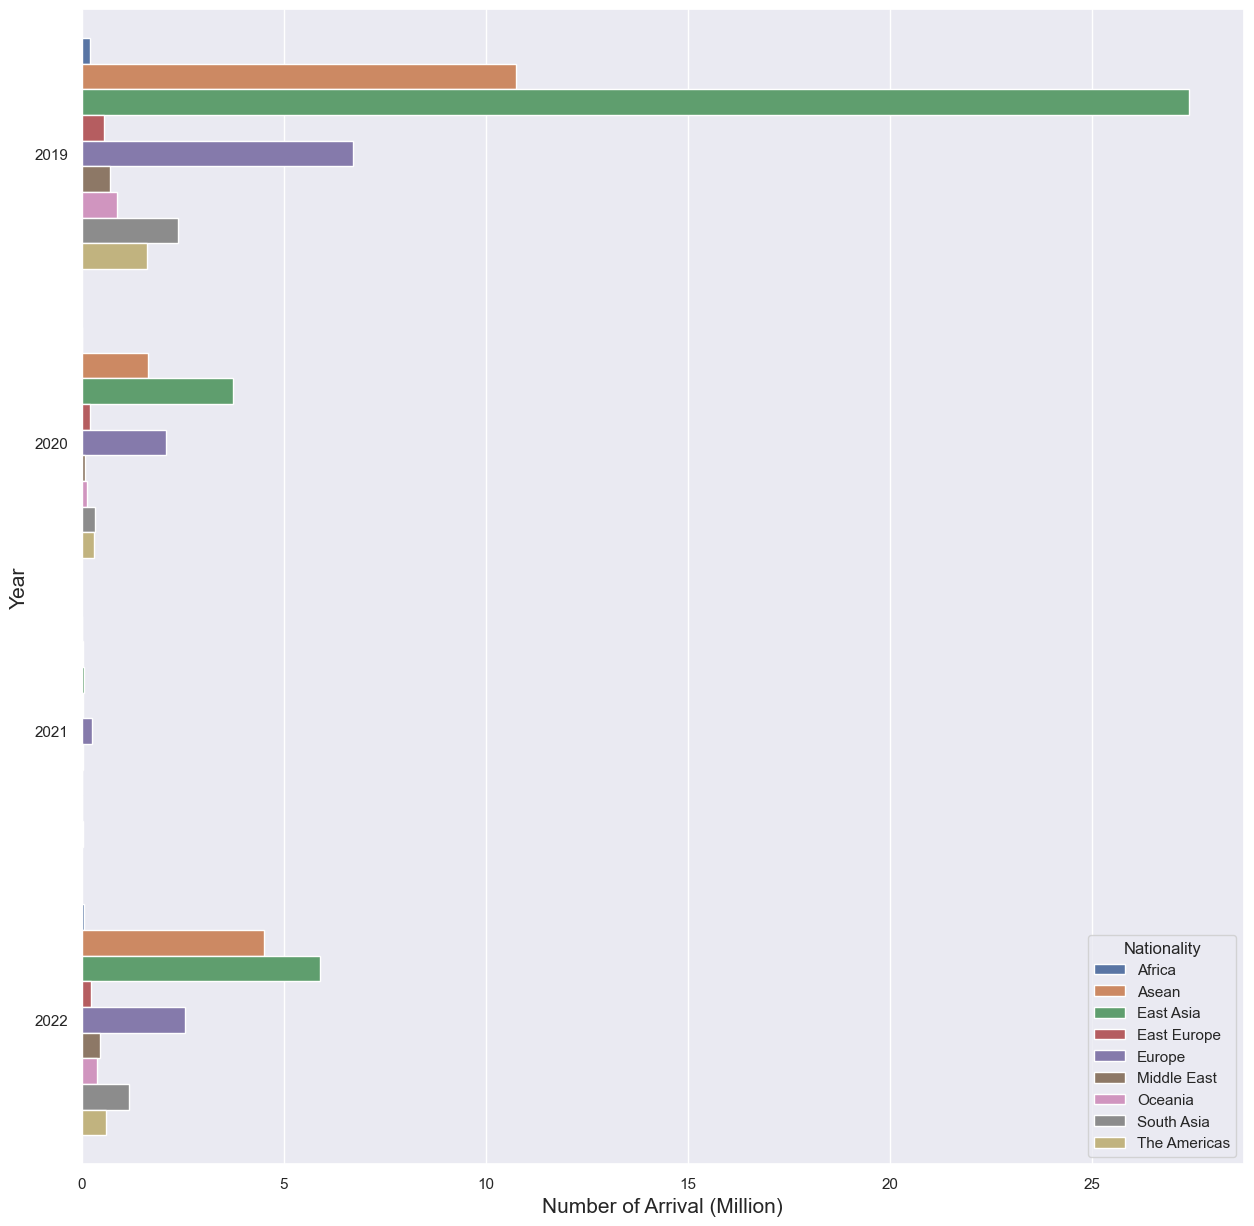

In [896]:
fig, axes = plt.subplots( figsize=(15, 15))
axes.ticklabel_format(axis='x', style='plain')

sns.barplot(region_th_arrival_melt,x='num_arrival',y='year',hue='Nationality')
axes.set_xlabel('Number of Arrival (Million)',fontdict={'size':15})
axes.set_ylabel('Year',fontdict={'size':15})

<AxesSubplot: xlabel='year', ylabel='num_arrival'>

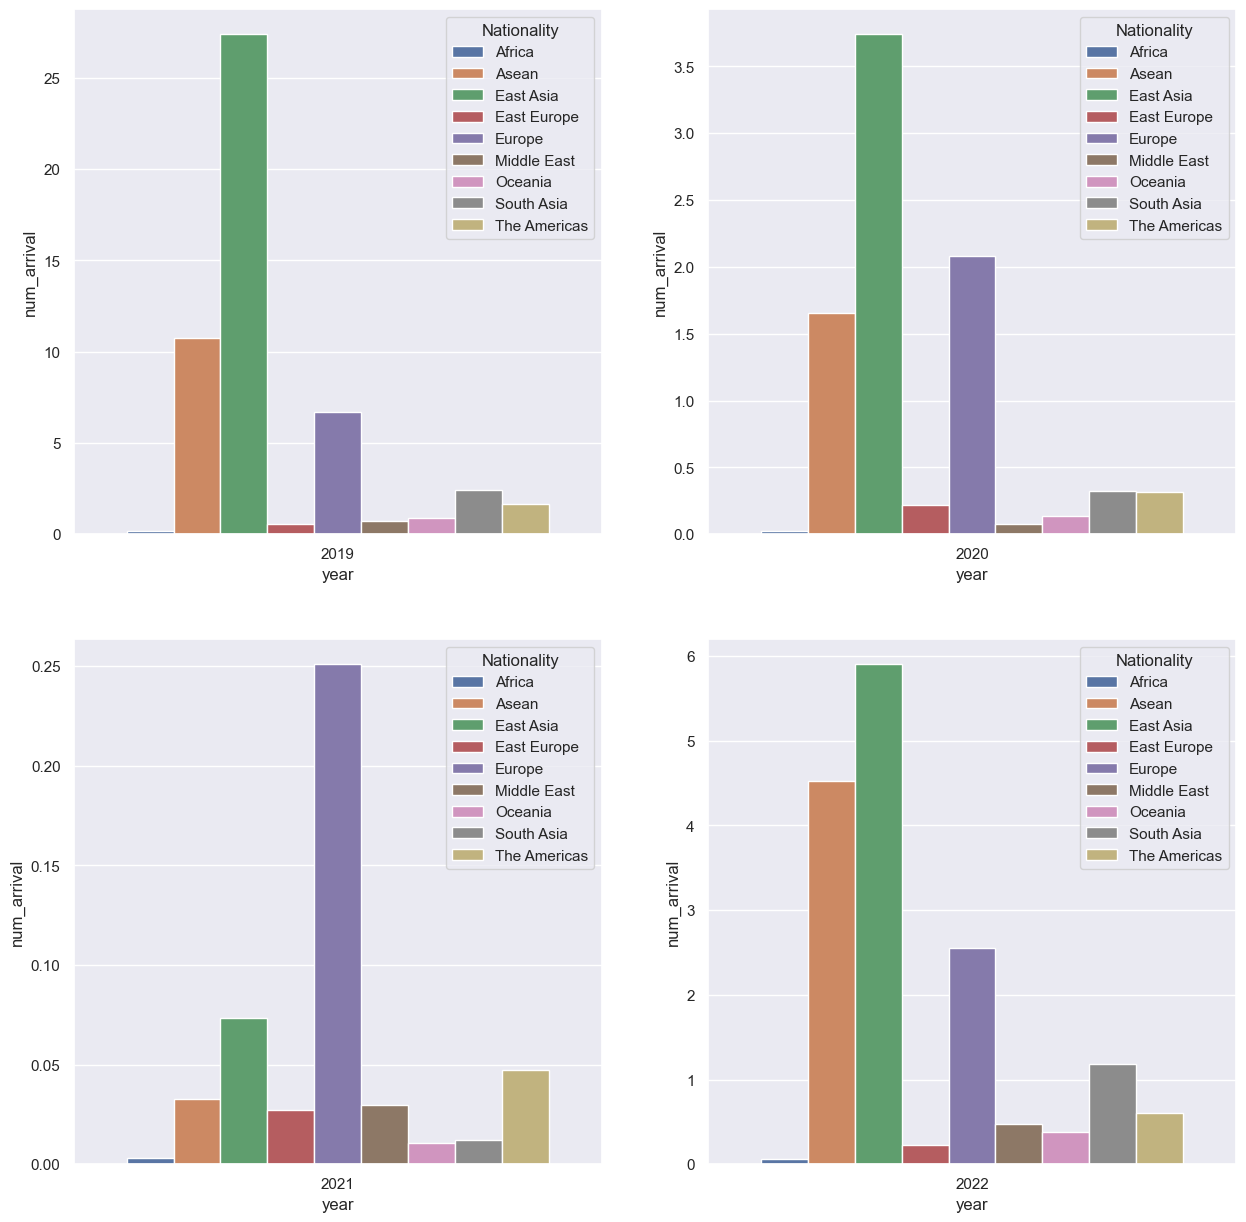

In [897]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# axes.ticklabel_format(axis='y', style='plain')

sns.barplot(region_th_arrival_melt.loc[region_th_arrival_melt['year'].isin(['2019'])],x='year',y='num_arrival',hue='Nationality',ax=axes[0,0])
sns.barplot(region_th_arrival_melt.loc[region_th_arrival_melt['year'].isin(['2020'])],x='year',y='num_arrival',hue='Nationality',ax=axes[0,1])
sns.barplot(region_th_arrival_melt.loc[region_th_arrival_melt['year'].isin(['2021'])],x='year',y='num_arrival',hue='Nationality',ax=axes[1,0])
sns.barplot(region_th_arrival_melt.loc[region_th_arrival_melt['year'].isin(['2022'])],x='year',y='num_arrival',hue='Nationality',ax=axes[1,1])

#### Number of Arrival from Asia

Text(0, 0.5, 'Year')

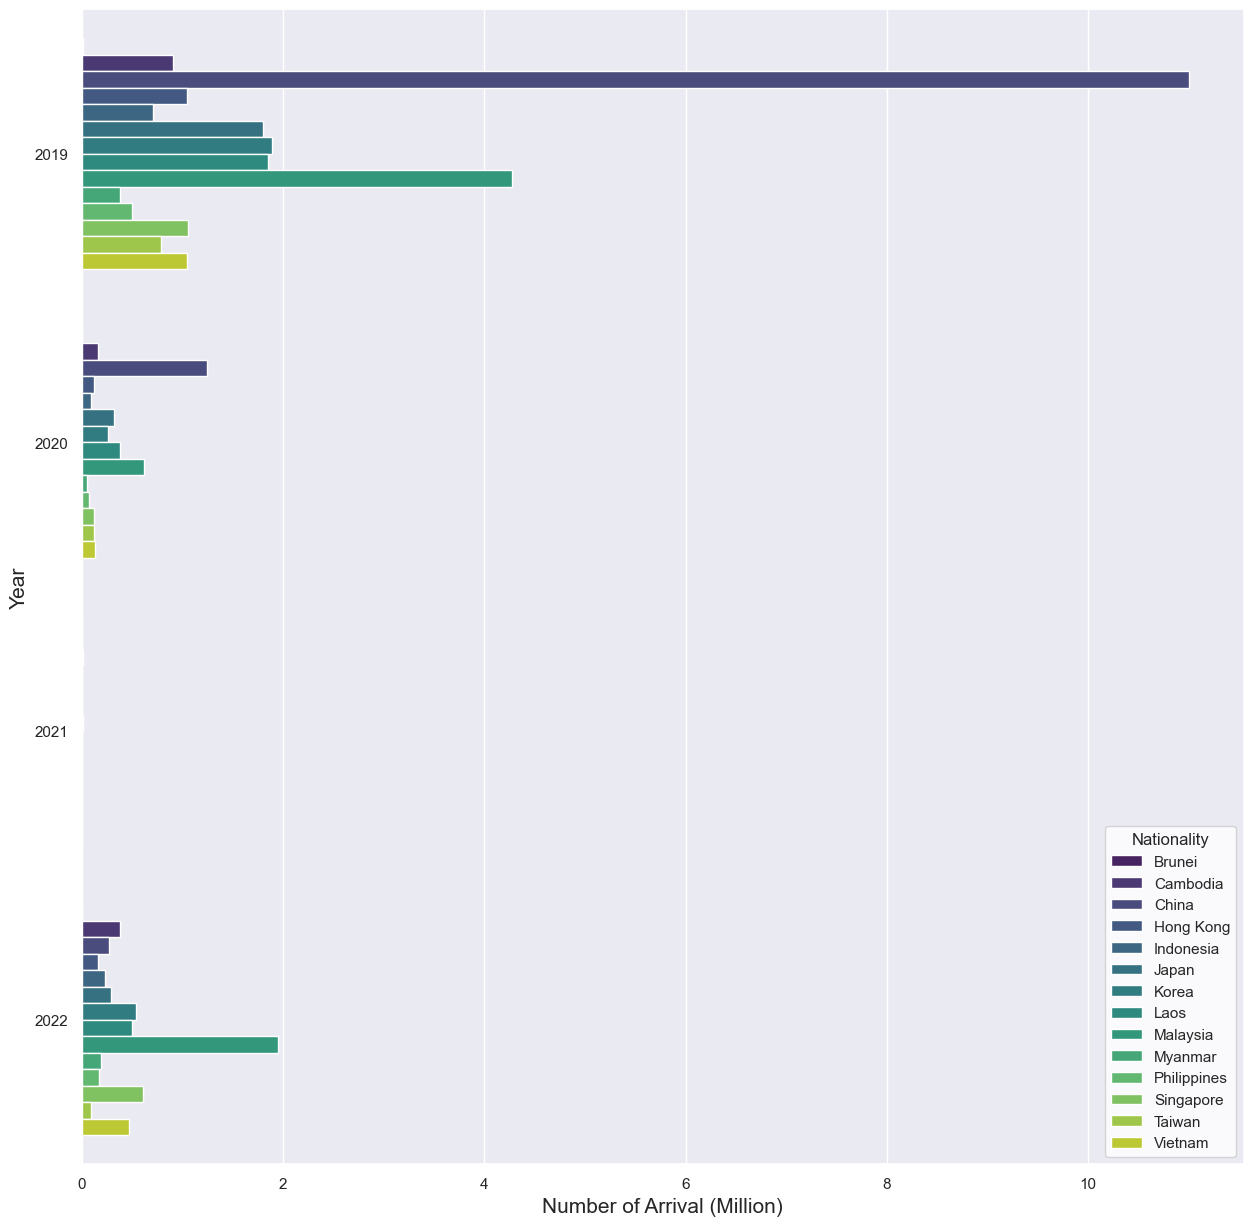

In [898]:
fig, axes = plt.subplots( figsize=(15, 15))
axes.ticklabel_format(axis='x', style='plain')
sns.set_theme(style="whitegrid")

axes = sns.barplot(country_th_arrival_melt.loc[country_th_arrival_melt['Nationality'].isin(region_dict['East Asia'])],
            x='num_arrival',y='year',hue='Nationality',palette='viridis')
axes.set_xlabel('Number of Arrival (Million)',fontdict={'size':15})
axes.set_ylabel('Year',fontdict={'size':15})

ValueError: Could not interpret input 'pct_change'

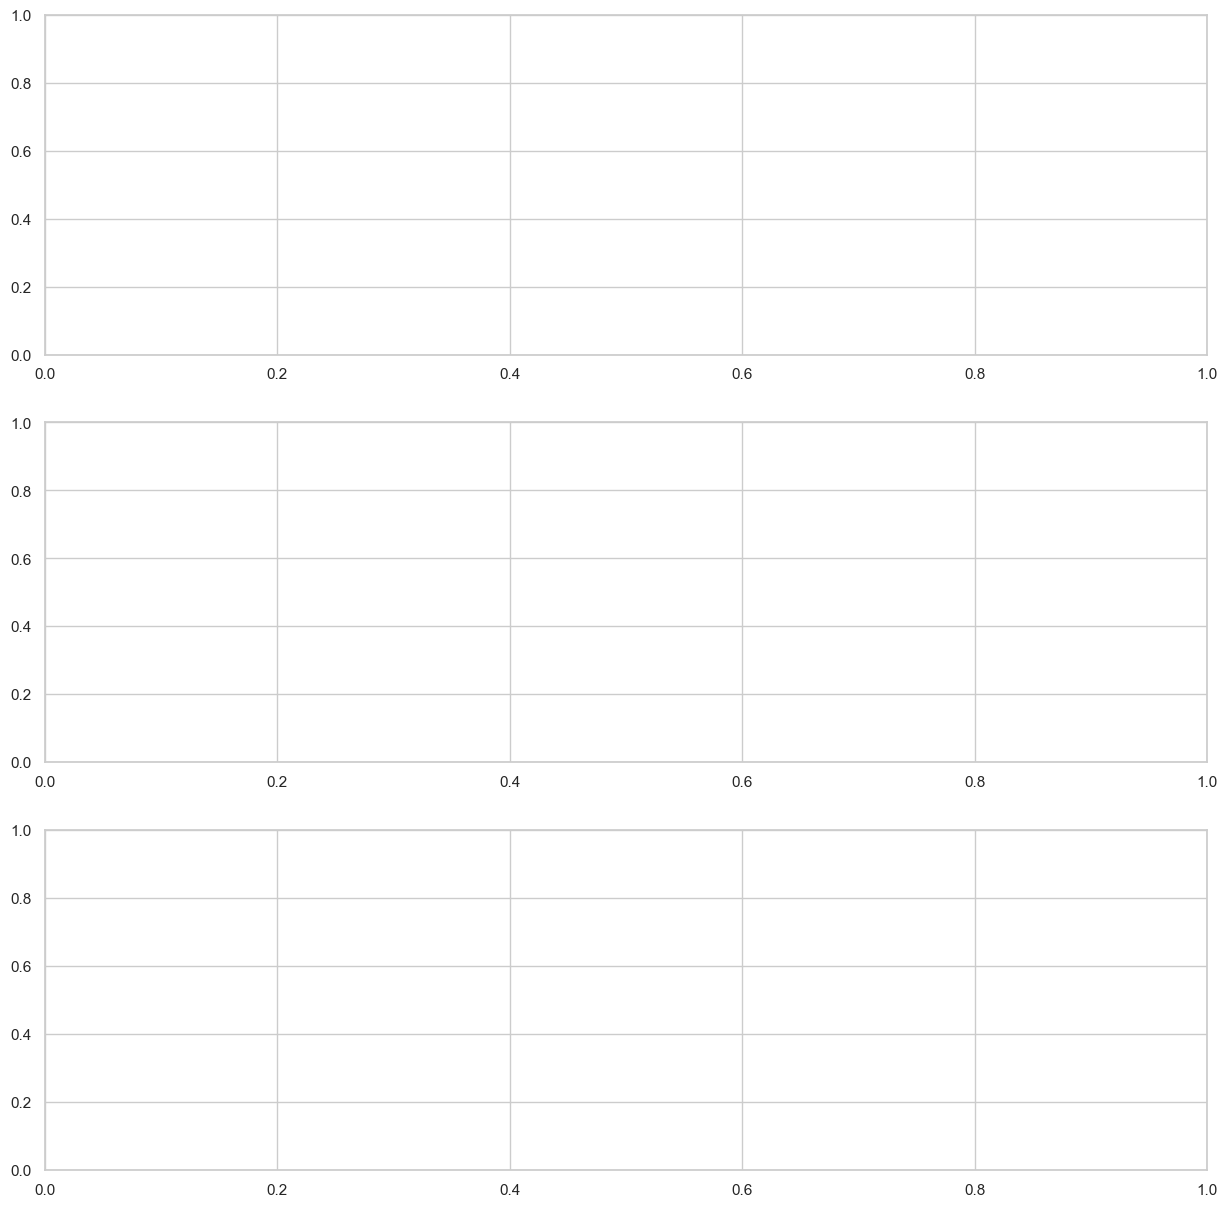

In [899]:
fig,(ax1,ax2,ax3) = plt.subplots(3, figsize=(15, 15))
# axes.ticklabel_format(axis='x', style='plain')
sns.set_theme(style="whitegrid")

sns.barplot(region_th_arrival_melt.loc[(region_th_arrival_melt['Nationality'].isin(region_list)) & (region_th_arrival_melt['year'].isin(['2020']))],
            x='pct_change',y='Nationality',ax=ax1,palette='viridis').set(xlabel='2020 Change (%)')
sns.barplot(region_th_arrival_melt.loc[(region_th_arrival_melt['Nationality'].isin(region_list)) & (region_th_arrival_melt['year'].isin(['2021']))],
            x='pct_change',y='Nationality',ax=ax2,palette='viridis').set(xlabel='2021 Change (%)')
sns.barplot(region_th_arrival_melt.loc[(region_th_arrival_melt['Nationality'].isin(region_list)) & (region_th_arrival_melt['year'].isin(['2022']))],
            x='pct_change',y='Nationality',ax=ax3,palette='viridis').set(xlabel='2022 Change (%)')